In [212]:
import numpy as np
from matplotlib import gridspec
import matplotlib.pyplot as plt
from numpy import exp as E, heaviside as H

In [213]:
class SpikeGenerator:
    def __init__(self, sensors, dist_param):
        self.sensors = sensors
        self.delay_dist = lambda: np.random.poisson(dist_param) 
        
    def generate_sensor(self, duration):
        delay = self.delay_dist()
        spike_distr = []
        for tick in range(duration):
            if delay <= 0:
                delay = self.delay_dist()
                spike_distr.append(1)
            else:
                spike_distr.append(0)
            delay -= 1
        return spike_distr
                
    def generate(self, duration):
        spike_distr_sensors = []
        for sensor in range(self.sensors):
            spike_distr_sensors.append(self.generate_sensor(duration))
        return np.array(spike_distr_sensors)
        

In [214]:
class SRM:
    def __init__(self, sensors_dim: int=5,
                       hidden_start: int=10,
                       hidden_end: int= 20,
                       out_dim: int=2,
                       thresh: float=0.5):
        self.sensors_dim = sensors_dim
        self.hidden_start = hidden_start
        self.hidden_end = hidden_end
        self.out_dim = out_dim
        self.thresh = thresh
        
        self.dim_tuples = ((sensors_dim, hidden_start), (hidden_start, hidden_end), (hidden_end, out_dim))
        self.dim_list = [sensors_dim, hidden_start, hidden_end, out_dim]
        
        self.generate_delay = lambda in_, out_: np.random.uniform(1, 5, size=(in_, out_))
        self.generate_weight = lambda in_, out_: np.random.uniform(0, 1, size=(in_, out_))
        self.generate_row = lambda dim: np.zeros(shape=(dim, ))
        self.generate_matrix = lambda dim1, dim2: np.zeros(shape=(dim1, dim2))
        
        self.reset()
        
        self.eta = lambda s: - E(-s) * H(s, 0)
        self.eps = lambda s:  s * E(s) * H(s, 0)
    
    def u(self, t, idx, times):
        t_next = times[idx + 1]
        t_curr = times[idx]
        
        n_ = self.eta(t - t_next)
        e_ = self.eps(t - t_next - self.delays[idx])
  
        return n_ + (self.weights[idx] * e_).sum(axis=0)
                      
    def reset(self):
        self.delays = [self.generate_delay(*i) for i in self.dim_tuples]
        self.weights = [self.generate_weight(*i) for i in self.dim_tuples]
        
    def init_(self, duration):
        times = [self.generate_row(dim) for dim in self.dim_list]
        voltages = [self.generate_matrix(dim, duration) for dim in self.dim_list[1:]]
        spikes = [self.generate_matrix(dim, duration) for dim in self.dim_list[1:]]
        return times, voltages, spikes
        
    def feedforward(self, spike_distr, duration):
        times, voltages, spikes = self.init_(duration)  
        for tick in range(duration):
            for i, (voltage, spike) in enumerate(zip(voltages, spikes)):
                voltage[:, tick] = self.u(tick, i, times)
                spike[:, tick] = (voltage[:, tick] >= self.thresh).astype(int)
            for j, time in enumerate(times):
                if not j:
                    times[j] = np.maximum(time, tick * spike_distr[:, tick])
                else:
                    times[j] = np.maximum(time, tick * spikes[j-1][:, tick])
        return times, voltages, spikes

In [246]:
def run_exp():
    time_range = 250
    time_arange = np.arange(time_range)
    sensors = 5
    dist_param = 5
    SG = SpikeGenerator(sensors, dist_param)
    SRM_ = SRM(thresh=0.01)
    
    times, voltages, spikes = SRM_.feedforward(SG.generate(time_range), time_range)
    
    
    fig = plt.figure(constrained_layout=True, figsize=(20, 10))
    spec = gridspec.GridSpec(ncols=6, nrows=4, figure=fig)
    
    ax11 = fig.add_subplot(spec[0:2, 0:2])
    ax12 = fig.add_subplot(spec[0:2, 2:4])
    ax13 = fig.add_subplot(spec[0:2, 4:6])

    ax21 = fig.add_subplot(spec[2:4, 0:2])
    ax22 = fig.add_subplot(spec[2:4, 2:4])
    ax23 = fig.add_subplot(spec[2:4, 4:6])


    ax11.plot(time_arange, spikes[0].mean(axis=0))
    ax11.set_title('hidden 1')
    ax11.set_xlabel('Время')
    ax11.set_ylabel('Доля активных нейронов')
    ax12.plot(time_arange, spikes[1].mean(axis=0))
    ax12.set_title('hidden 2')
    ax12.set_xlabel('Время')
    ax12.set_ylabel('Доля активных нейронов')
    ax13.plot(time_arange, spikes[2].mean(axis=0))
    ax13.set_title('hidden 3')
    ax13.set_xlabel('Время')
    ax13.set_ylabel('Доля активных нейронов')


    ax21.plot(time_arange, spikes[0][spikes[0].sum(axis=1).argmax()])
    ax21.set_title('hidden 1')
    ax21.set_xlabel('Время')
    ax21.set_ylabel('Активный спайк')
    ax22.plot(time_arange, spikes[1][spikes[1].sum(axis=1).argmax()])
    ax22.set_title('hidden 2')
    ax22.set_xlabel('Время')
    ax22.set_ylabel('Активный спайк')
    ax23.plot(time_arange, spikes[2][spikes[2].sum(axis=1).argmax()])
    ax23.set_title('hidden 3')
    ax23.set_xlabel('Время')
    ax23.set_ylabel('Активный спайк')





    for mg in [ax11, ax12, ax13, ax21, ax22, ax23]:
        mg.grid()

    plt.show()
    
    
    

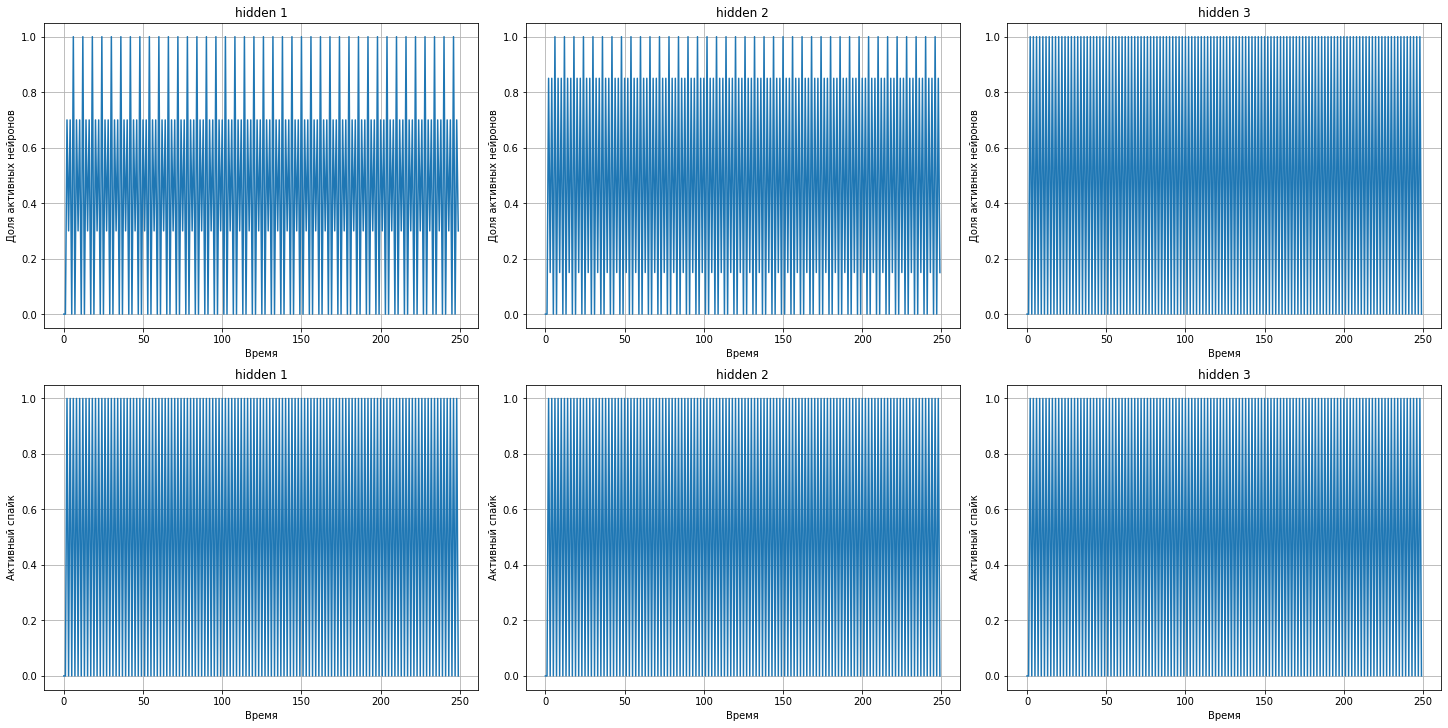

In [247]:
# эксперимент 1
run_exp()

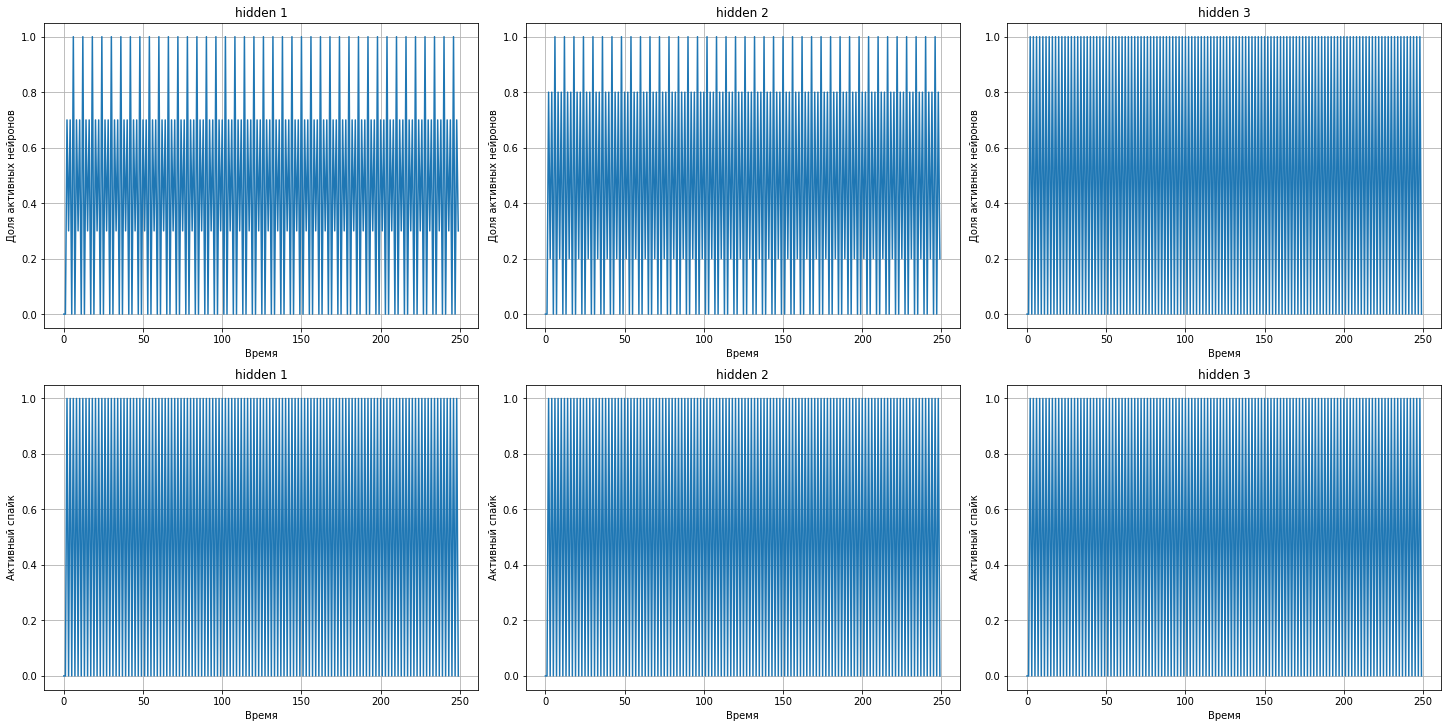

In [248]:
# эксперимент 2
run_exp()

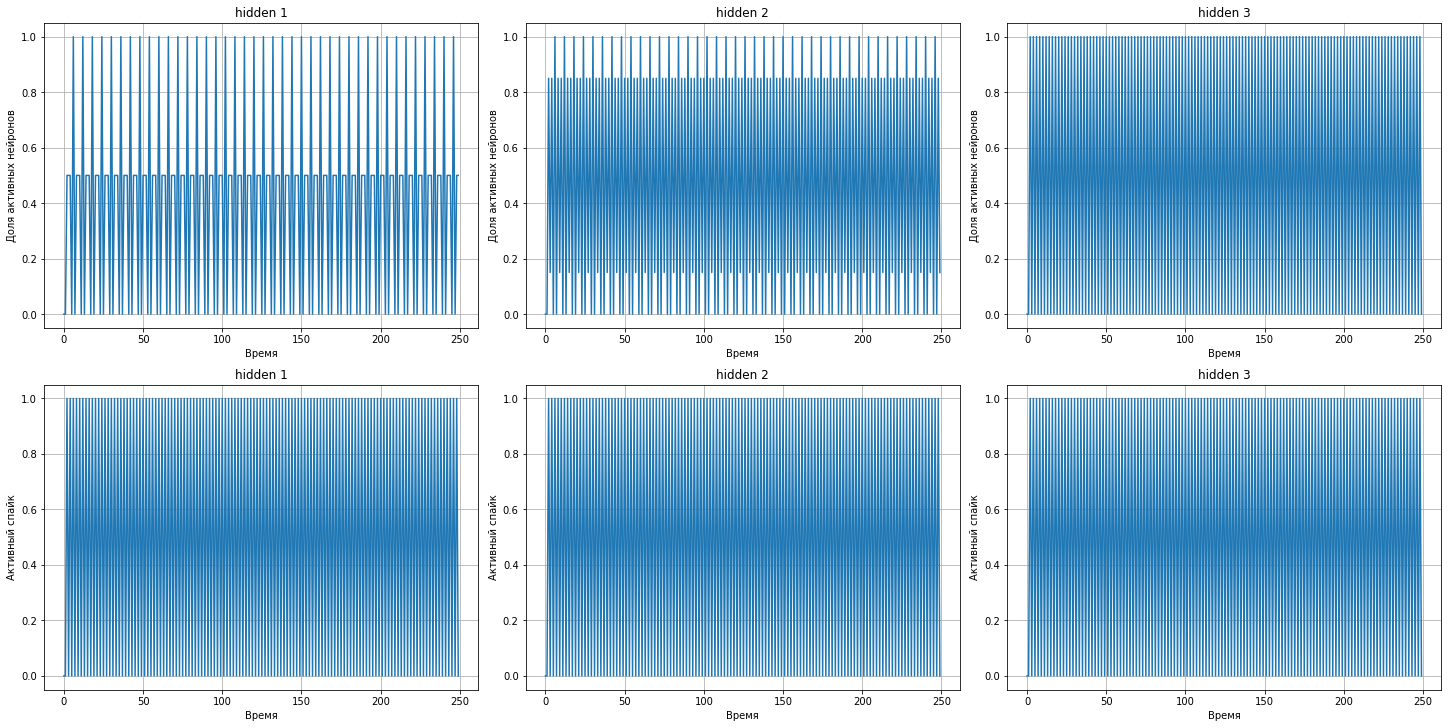

In [249]:
# эксперимент 3
run_exp()